<a href="https://colab.research.google.com/github/avinashganguri/PJM-Energy-Usage/blob/main/PJM_Energy_Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

In [7]:
# Auth google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/aep.csv', index_col='Datetime')
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/comed.csv', index_col='Datetime')
df3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/dayton.csv', index_col='Datetime')
df4 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/deok.csv', index_col='Datetime')
df5 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/dom.csv', index_col='Datetime')
df6 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/duq.csv', index_col='Datetime')
df7 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/ekpc.csv', index_col='Datetime')
df8 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/fe.csv', index_col='Datetime')
df9 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/ni.csv', index_col='Datetime')
df10 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/pjme.csv', index_col='Datetime')
df11 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/energy-usage/pjmw.csv', index_col='Datetime')

df_final = df1.join([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

# Using dayton.csv for modeling since the approach is the same for others
df = df3

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125361 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     125361 non-null  float64
 1   COMED_MW   70583 non-null   float64
 2   DAYTON_MW  125361 non-null  float64
 3   DEOK_MW    61825 non-null   float64
 4   DOM_MW     120275 non-null  float64
 5   DUQ_MW     123154 non-null  float64
 6   EKPC_MW    49421 non-null   float64
 7   FE_MW      66960 non-null   float64
 8   NI_MW      54778 non-null   float64
 9   PJME_MW    125361 non-null  float64
 10  PJMW_MW    125361 non-null  float64
dtypes: float64(11)
memory usage: 11.5+ MB


In [10]:
df_final.describe()

AEP_MW      COMED_MW      DAYTON_MW       DEOK_MW  \
count  125361.000000  70583.000000  125361.000000  61825.000000   
mean    15363.077847  11237.756174    2017.668996   3041.597541   
std      2661.589281   2357.022834     402.920846    637.299488   
min      9581.000000   7237.000000     982.000000    907.000000   
25%     13416.000000   9496.000000    1716.000000   2594.000000   
50%     15206.000000  11018.000000    1994.000000   2971.000000   
75%     17121.000000  12397.000000    2267.000000   3409.000000   
max     25695.000000  23753.000000    3746.000000   5445.000000   

              DOM_MW         DUQ_MW       EKPC_MW         FE_MW         NI_MW  \
count  120275.000000  123154.000000  49421.000000  66960.000000  54778.000000   
mean    10845.028119    1642.043401   1435.357722   7663.627688  11713.761236   
std      2438.253016     310.399093    382.815695   1386.468697   2363.414180   
min      1253.000000    1014.000000    514.000000      0.000000   7003.000000   
25%      9154.000000    1423.000000   1153.000000   6608.000000   9981.000000   
50%     10402.000000    1618.000000   1365.000000   7606.000000  11530.000000   
75%     12287.500000    1811.000000   1667.000000   8483.000000  12891.000000   
max     21651.000000    3054.000000   3490.000000  14032.000000  23631.000000   

             PJME_MW        PJMW_MW  
count  125361.000000  125361.000000  
mean    31759.038983    5531.513541  
std      6643.720256    1008.678744  
min     14544.000000    2553.000000  
25%     27103.000000    4788.000000  
50%     31182.000000    5447.000000  
75%     35451.000000    6199.000000  
max     62009.000000    9594.000000

Text(0.5, 1.0, 'Energy Cosumption PJM')

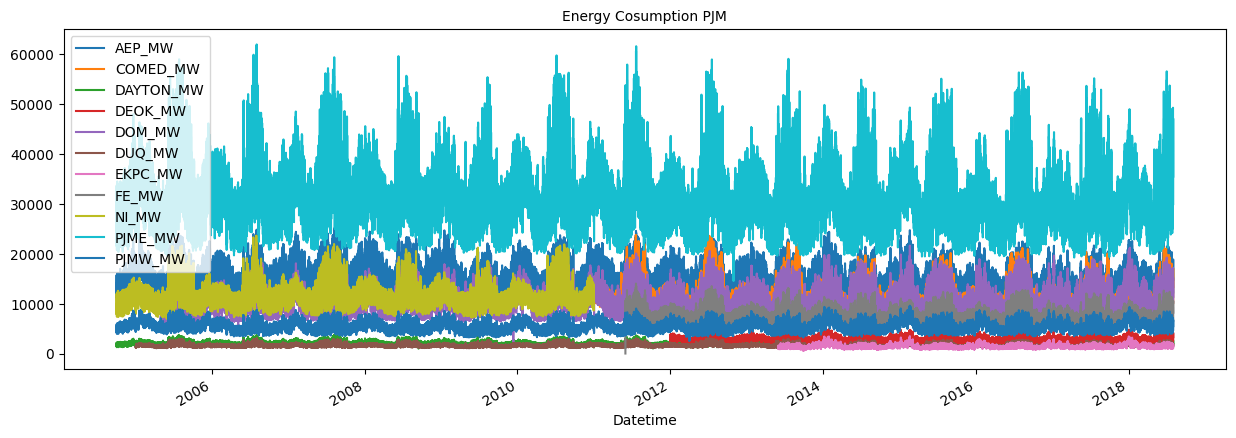

In [17]:
# EDA

df_final.index = pd.to_datetime(df_final.index)
df_final.plot(figsize=(15,5))
plt.title('Energy Cosumption PJM', fontsize=10)

At first glance, we can see that **PJME** has the highest energy consumption compared to the others, and the datetime columns do not align for **NI**, **EKPC**, and **DEOK**

Text(0.5, 1.0, 'PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08')

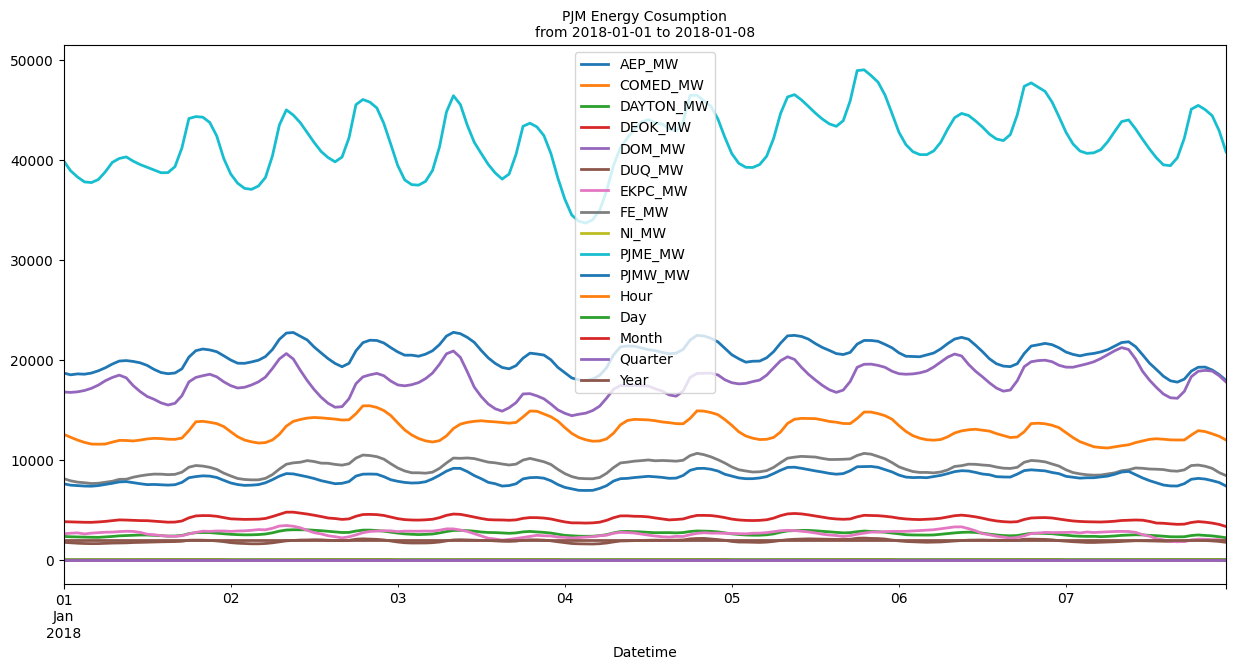

In [28]:
df_2018 = df_final[(df_final.index >= '2018-01-01') & (df_final.index < '2018-01-08')]

df_2018.plot(figsize=(15,7), lw=2)
plt.title('PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08', fontsize=10)

In [19]:
df_final['Hour'] = df_final.index.hour
df_final['Day'] = df_final.index.day
df_final['Month'] = df_final.index.month
df_final['Quarter'] = df_final.index.quarter
df_final['Year'] = df_final.index.year

df_final.head(3)

AEP_MW  COMED_MW  DAYTON_MW  DEOK_MW  DOM_MW  DUQ_MW  \
Datetime                                                                     
2004-10-01 01:00:00  12379.0       NaN     1621.0      NaN     NaN     NaN   
2004-10-01 02:00:00  11935.0       NaN     1536.0      NaN     NaN     NaN   
2004-10-01 03:00:00  11692.0       NaN     1500.0      NaN     NaN     NaN   

                     EKPC_MW  FE_MW   NI_MW  PJME_MW  PJMW_MW  Hour  Day  \
Datetime                                                                   
2004-10-01 01:00:00      NaN    NaN  9305.0  24025.0   4628.0     1    1   
2004-10-01 02:00:00      NaN    NaN  8681.0  22845.0   4520.0     2    1   
2004-10-01 03:00:00      NaN    NaN  8314.0  22138.0   4431.0     3    1   

                     Month  Quarter  Year  
Datetime                                   
2004-10-01 01:00:00     10        4  2004  
2004-10-01 02:00:00     10        4  2004  
2004-10-01 03:00:00     10        4  2004

In [20]:
print(df_final[df_final.index.duplicated()].index.unique())

DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


In [21]:
df_final.index.unique()

DatetimeIndex(['2004-10-01 01:00:00', '2004-10-01 02:00:00',
               '2004-10-01 03:00:00', '2004-10-01 04:00:00',
               '2004-10-01 05:00:00', '2004-10-01 06:00:00',
               '2004-10-01 07:00:00', '2004-10-01 08:00:00',
               '2004-10-01 09:00:00', '2004-10-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121269, freq=None)

In [22]:
df_final[df_final.index == '2014-11-02 02:00:00']

AEP_MW  COMED_MW  DAYTON_MW  DEOK_MW  DOM_MW  DUQ_MW  \
Datetime                                                                     
2014-11-02 02:00:00  12994.0    8869.0     1623.0   2518.0  8555.0  1272.0   
2014-11-02 02:00:00  12994.0    8869.0     1623.0   2518.0  8555.0  1272.0   
2014-11-02 02:00:00  12994.0    8869.0     1623.0   2518.0  8555.0  1272.0   
2014-11-02 02:00:00  12994.0    8869.0     1623.0   2518.0  8555.0  1272.0   
2014-11-02 02:00:00  12994.0    8869.0     1623.0   2518.0  8555.0  1272.0   
...                      ...       ...        ...      ...     ...     ...   
2014-11-02 02:00:00  13190.0    9184.0     1634.0   2562.0  8562.0  1240.0   
2014-11-02 02:00:00  13190.0    9184.0     1634.0   2562.0  8562.0  1240.0   
2014-11-02 02:00:00  13190.0    9184.0     1634.0   2562.0  8562.0  1240.0   
2014-11-02 02:00:00  13190.0    9184.0     1634.0   2562.0  8562.0  1240.0   
2014-11-02 02:00:00  13190.0    9184.0     1634.0   2562.0  8562.0  1240.0   

                     EKPC_MW   FE_MW  NI_MW  PJME_MW  PJMW_MW  Hour  Day  \
Datetime                                                                   
2014-11-02 02:00:00   1554.0  6051.0    NaN  22935.0   4613.0     2    2   
2014-11-02 02:00:00   1554.0  6051.0    NaN  22935.0   4571.0     2    2   
2014-11-02 02:00:00   1554.0  6051.0    NaN  23755.0   4613.0     2    2   
2014-11-02 02:00:00   1554.0  6051.0    NaN  23755.0   4571.0     2    2   
2014-11-02 02:00:00   1554.0  6185.0    NaN  22935.0   4613.0     2    2   
...                      ...     ...    ...      ...      ...   ...  ...   
2014-11-02 02:00:00   1566.0  6051.0    NaN  23755.0   4571.0     2    2   
2014-11-02 02:00:00   1566.0  6185.0    NaN  22935.0   4613.0     2    2   
2014-11-02 02:00:00   1566.0  6185.0    NaN  22935.0   4571.0     2    2   
2014-11-02 02:00:00   1566.0  6185.0    NaN  23755.0   4613.0     2    2   
2014-11-02 02:00:00   1566.0  6185.0    NaN  23755.0   4571.0     2    2   

                     Month  Quarter  Year  
Datetime                                   
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
...                    ...      ...   ...  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  
2014-11-02 02:00:00     11        4  2014  

[1024 rows x 16 columns]

In [25]:
# Grouping duplicate values
df_final = df_final.groupby(df_final.index).mean()

df_final['Hour'] = df_final['Hour'].astype(int)
df_final['Day'] = df_final['Day'].astype(int)
df_final['Month'] = df_final['Month'].astype(int)
df_final['Year'] = df_final['Year'].astype(int)

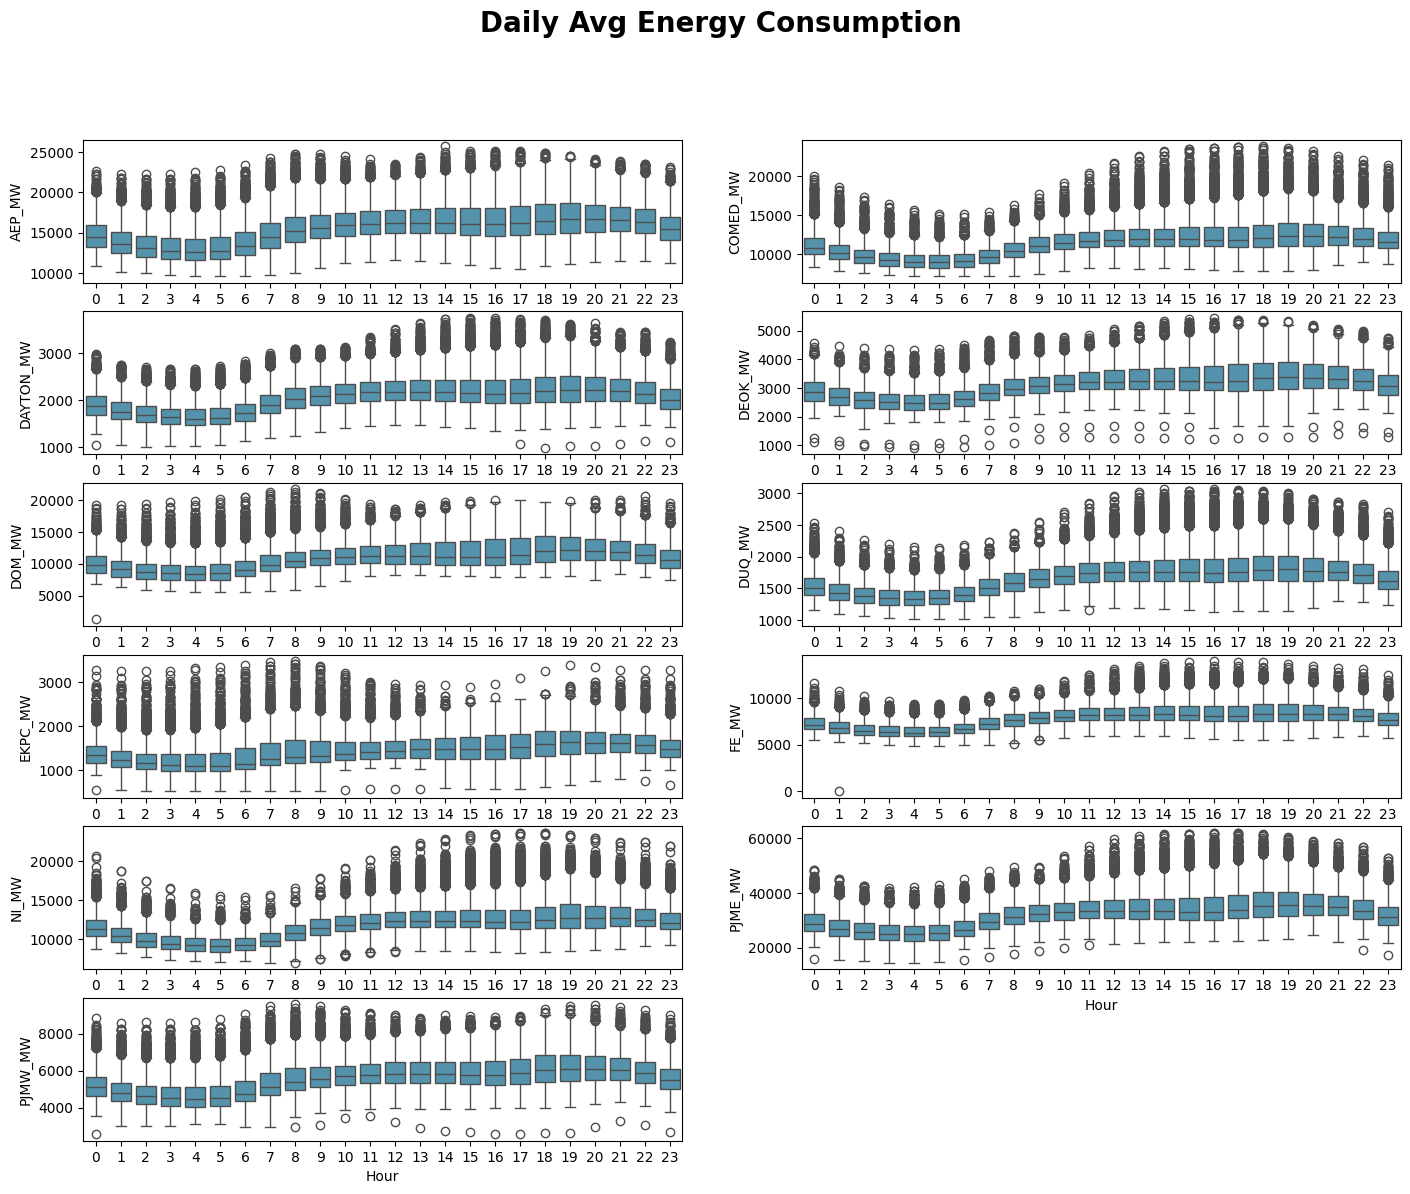

In [33]:
columns = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
           'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

f, axes = plt.subplots(nrows=6, ncols=2, figsize=(17, 13))
f.suptitle('Daily Avg Energy Consumption', weight='bold', fontsize=20)
# Deleting last one as we 11 figures is fine
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.boxplot(data=df_final, x='Hour', y=col, ax=axes.flatten()[i], color='#4599ba')

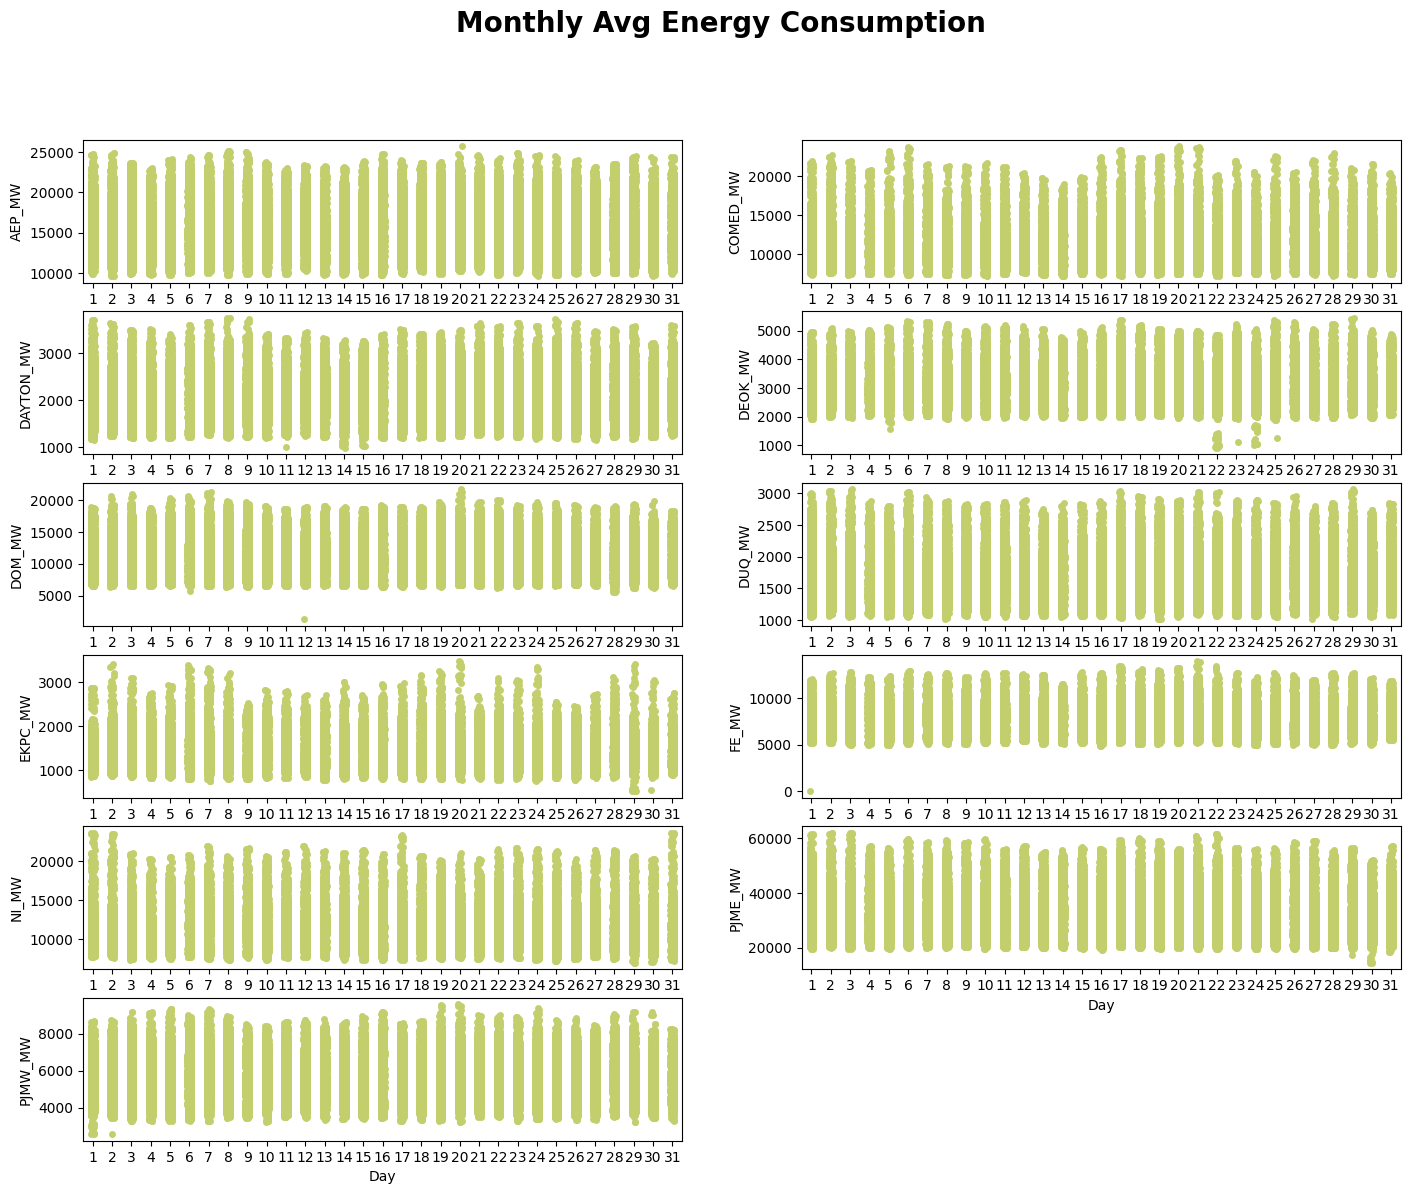

In [37]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(17, 13))
f.suptitle('Monthly Avg Energy Consumption', weight='bold', fontsize=20)
# Deleting last one as we 11 figures is fine
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.stripplot(data=df_final, x='Day', y=col, ax=axes.flatten()[i], color='#c3cf6d')

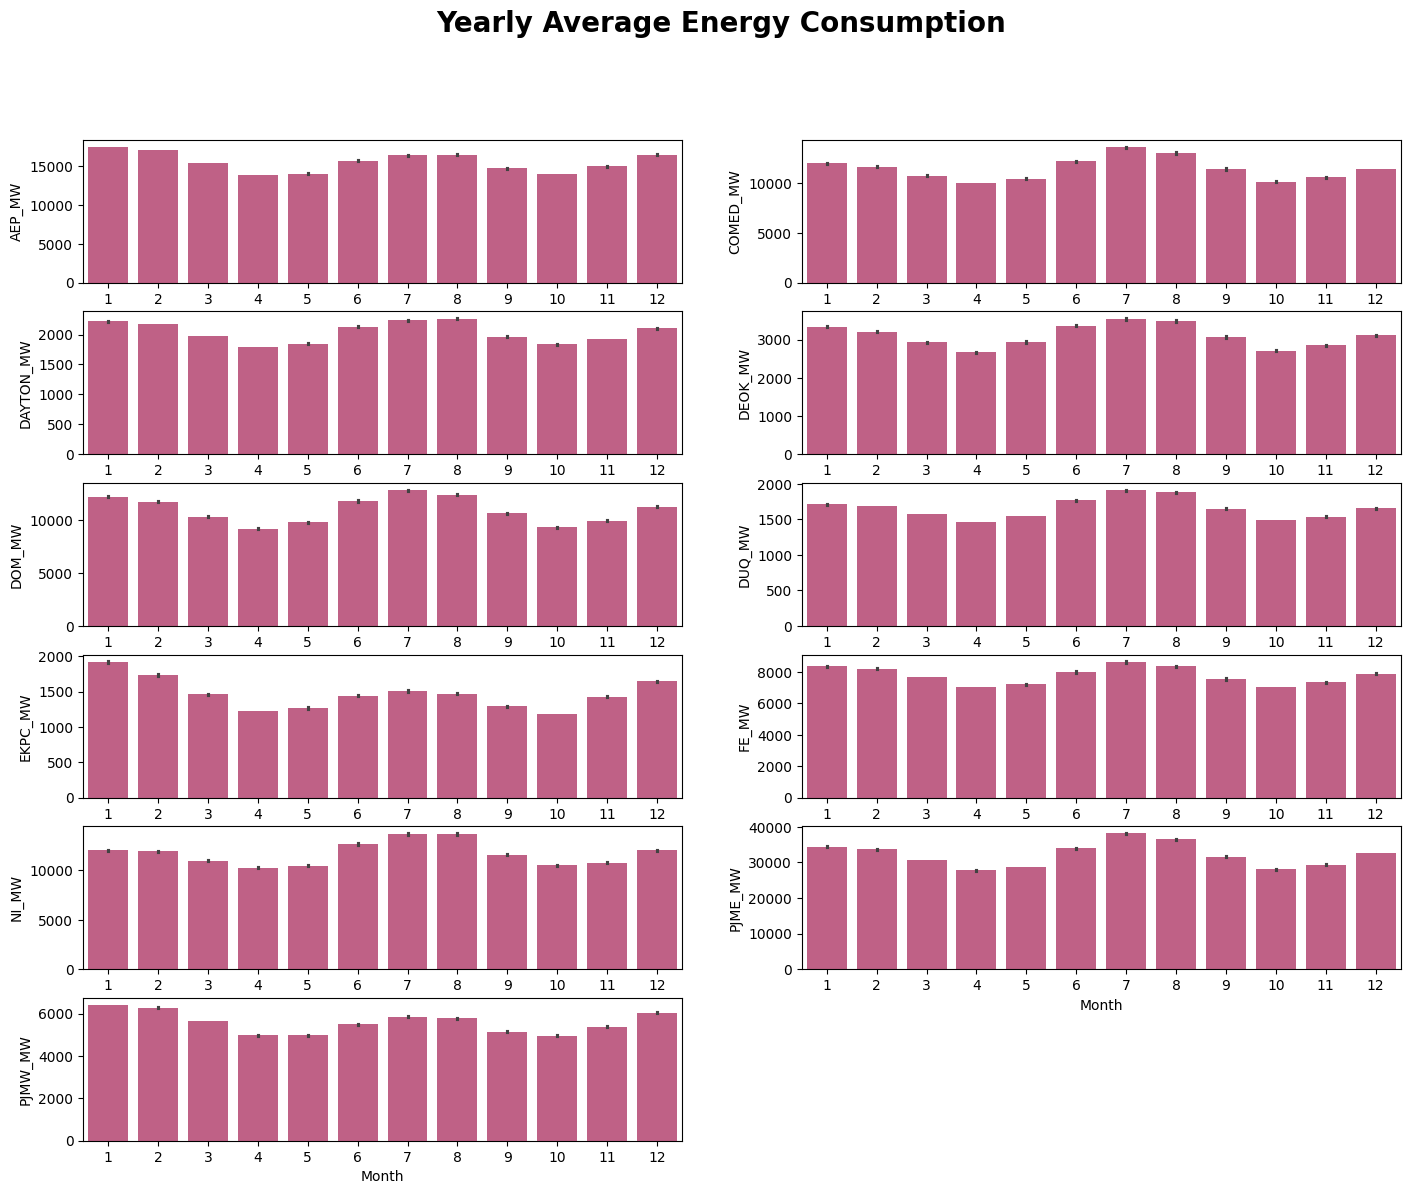

In [36]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(17, 13))
f.suptitle('Yearly Average Energy Consumption', weight='bold', fontsize=20)
# Deleting last one as we 11 figures is fine
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.barplot(data=df_final, x='Month', y=col, ax=axes.flatten()[i], color='#cf5183')

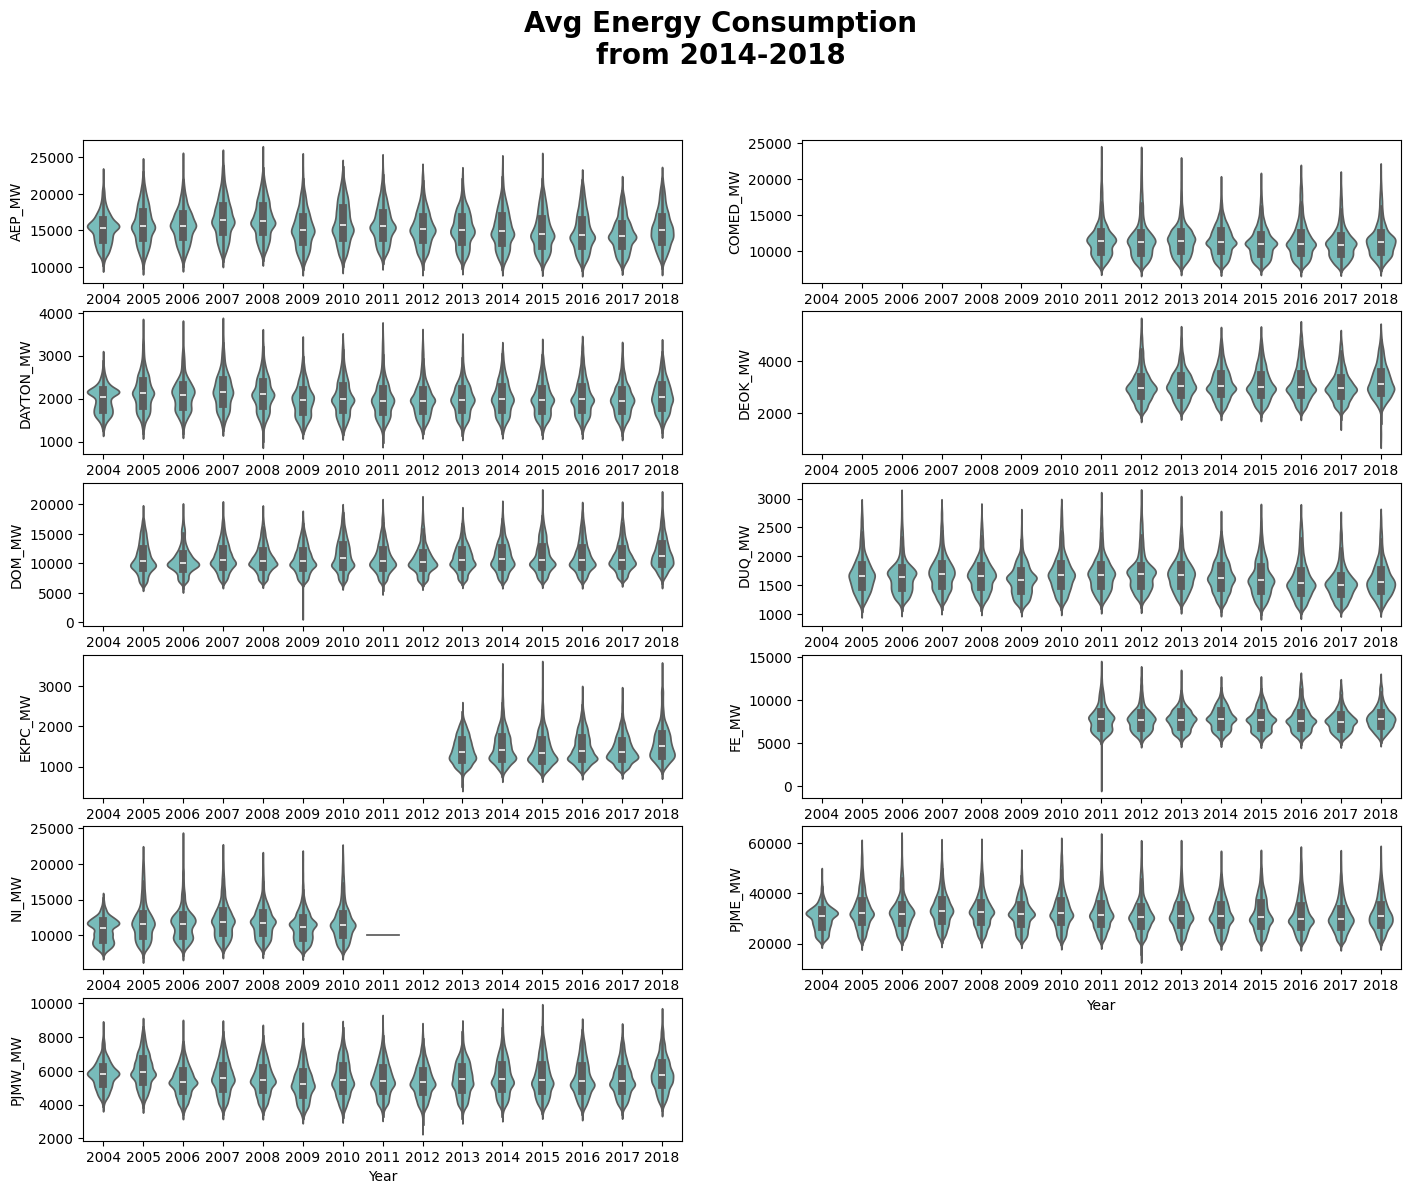

In [39]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(17, 13))
f.suptitle('Avg Energy Consumption\nfrom 2014-2018', weight='bold', fontsize=20)
# Deleting last one as we 11 figures is fine
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.violinplot(data=df_final, x='Year', y=col, ax=axes.flatten()[i], color='#6dc7c5')

Our data shows seasonality, which makes the visualizations quite similar across different data sets or columns. The only exception is the year, as some data points have missing values in certain years

We observed from above EDA that,
* The highest energy consumption in a year is in the middle of the year or either in the end of the year
* Daily peak/highest is around 6-8 PM and the trough/mininum is at 2 AM
* `PJME` holds the highest energy consumption among others
* Out of 11 data, 5 of them is not complete (2004-2018)

In [40]:
# Using the DAYTON_MW column to simplify the process, as the same approach applies to the rest of the data.
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#988acf', '#dba842'])

In [41]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

df.head()

DAYTON_MW
Datetime                      
2004-10-01 01:00:00     1621.0
2004-10-01 02:00:00     1536.0
2004-10-01 03:00:00     1500.0
2004-10-01 04:00:00     1434.0
2004-10-01 05:00:00     1489.0

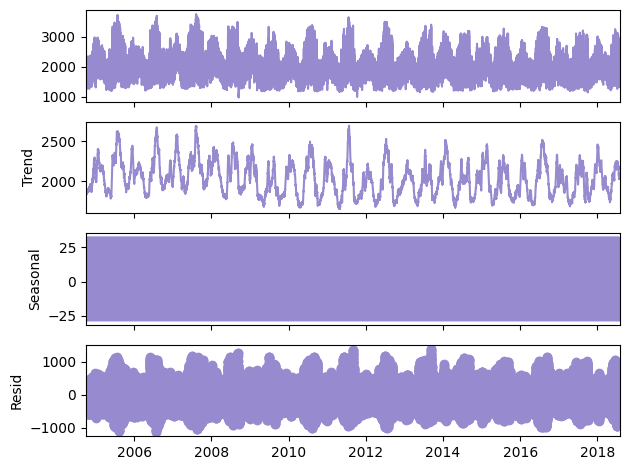

In [42]:
seasonal_decompose(df, period=365).plot()
plt.show()

In [43]:
# Moving Average for Daily Consumption
ma = df.resample('D').mean()

ma['Moving Average'] = ma['DAYTON_MW'].rolling(3).mean()
ma.head()

DAYTON_MW  Moving Average
Datetime                               
2004-10-01  1924.130435             NaN
2004-10-02  1641.583333             NaN
2004-10-03  1528.708333     1698.140700
2004-10-04  1926.541667     1698.944444
2004-10-05  1970.125000     1808.458333

In [45]:
def moving_average(data, window):
    data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
    actual = data['DAYTON_MW'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]

    plt.figure(figsize=(17,7))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Days Moving Average'.format(str(window)), fontsize=20)
    plt.legend()

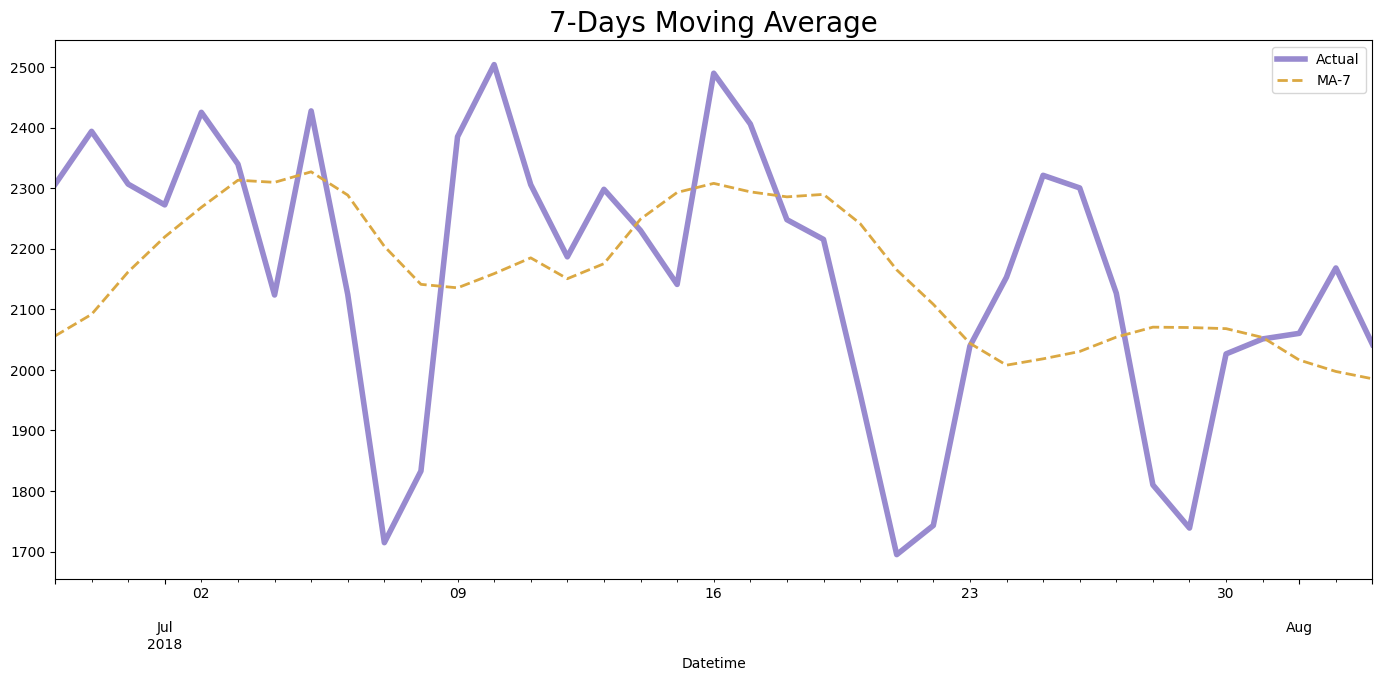

In [46]:
moving_average(ma, 7)

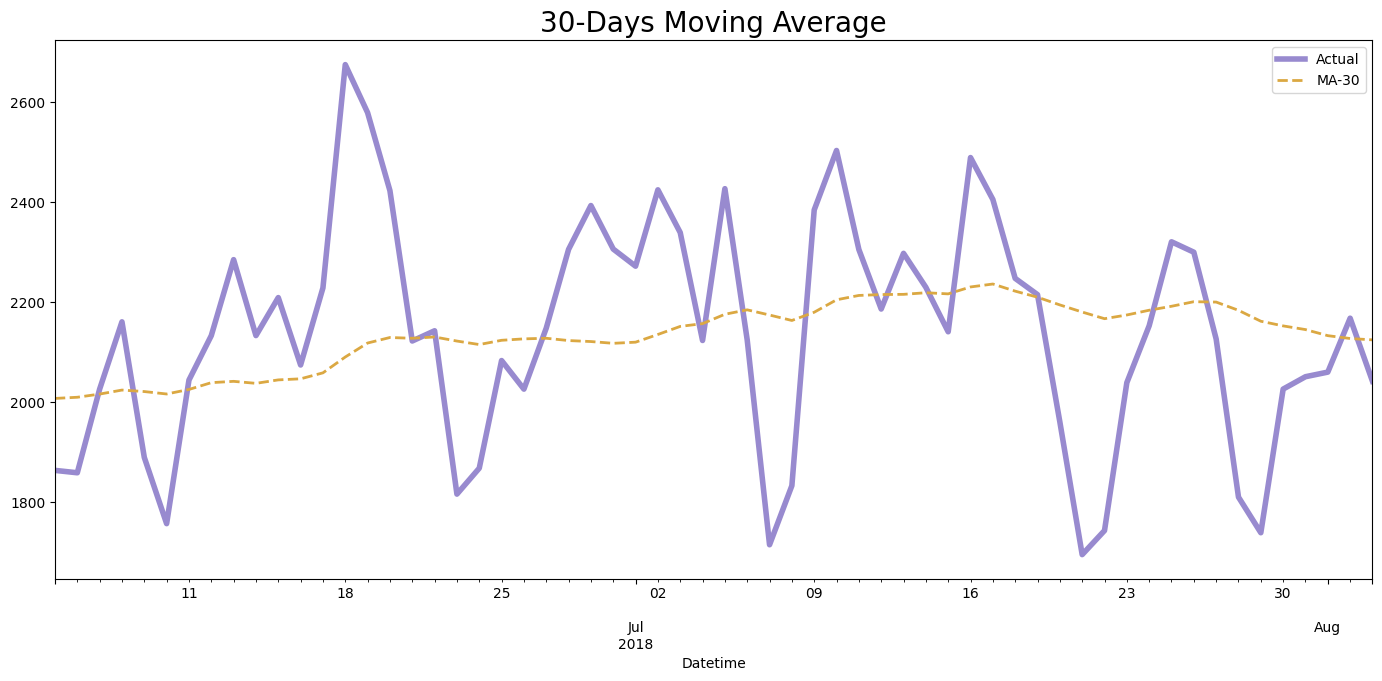

In [47]:
moving_average(ma, 30)

In [48]:
df_train, df_test = df[df.index < '2016-01-01'], df[df.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 98595
Test:	 22680


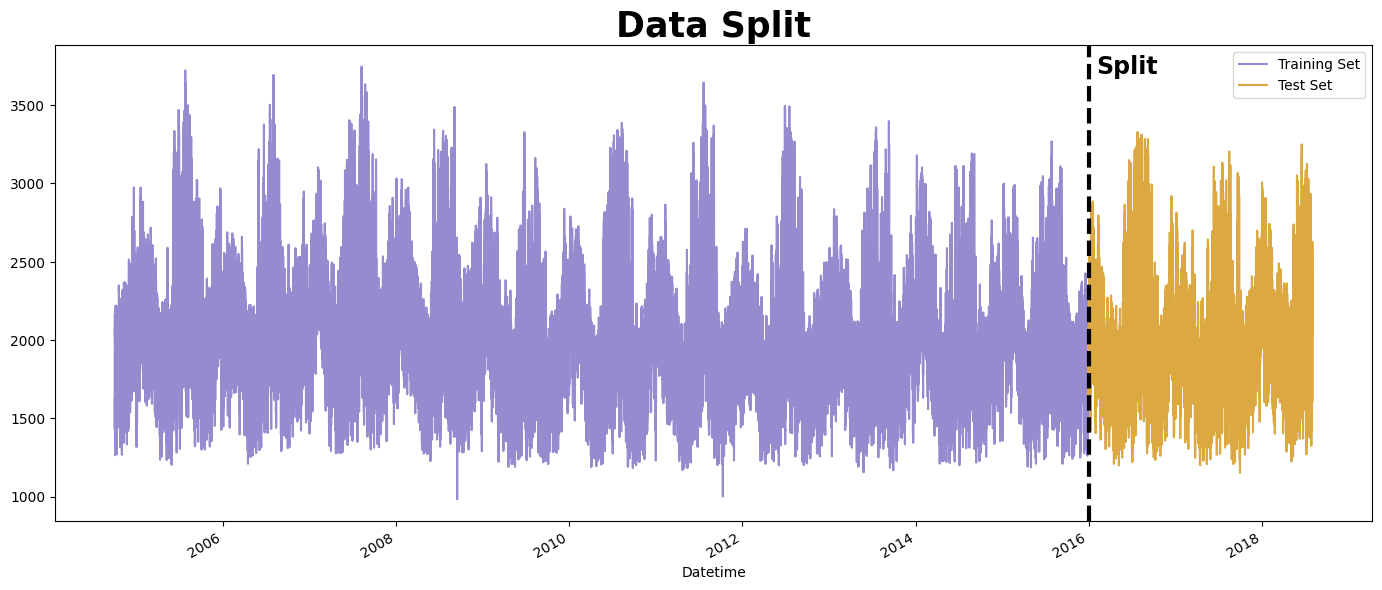

In [49]:
plt.figure(figsize=(17,7))

df_train['DAYTON_MW'].plot(label='Training Set')
df_test['DAYTON_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split', fontsize=17, fontweight='bold')
plt.title('Data Split', weight='bold', fontsize=25)
plt.legend()

<h1><b>1. Prophet</b></h1>

In [50]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')

    data = data.rename(columns={'Datetime': 'ds', 'DAYTON_MW': 'y'})
    return data

In [51]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [52]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg1uqoar/07nw7akz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg1uqoar/fdad9f56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34387', 'data', 'file=/tmp/tmpwg1uqoar/07nw7akz.json', 'init=/tmp/tmpwg1uqoar/fdad9f56.json', 'output', 'file=/tmp/tmpwg1uqoar/prophet_model_6a_h4y0/prophet_model-20240531191331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


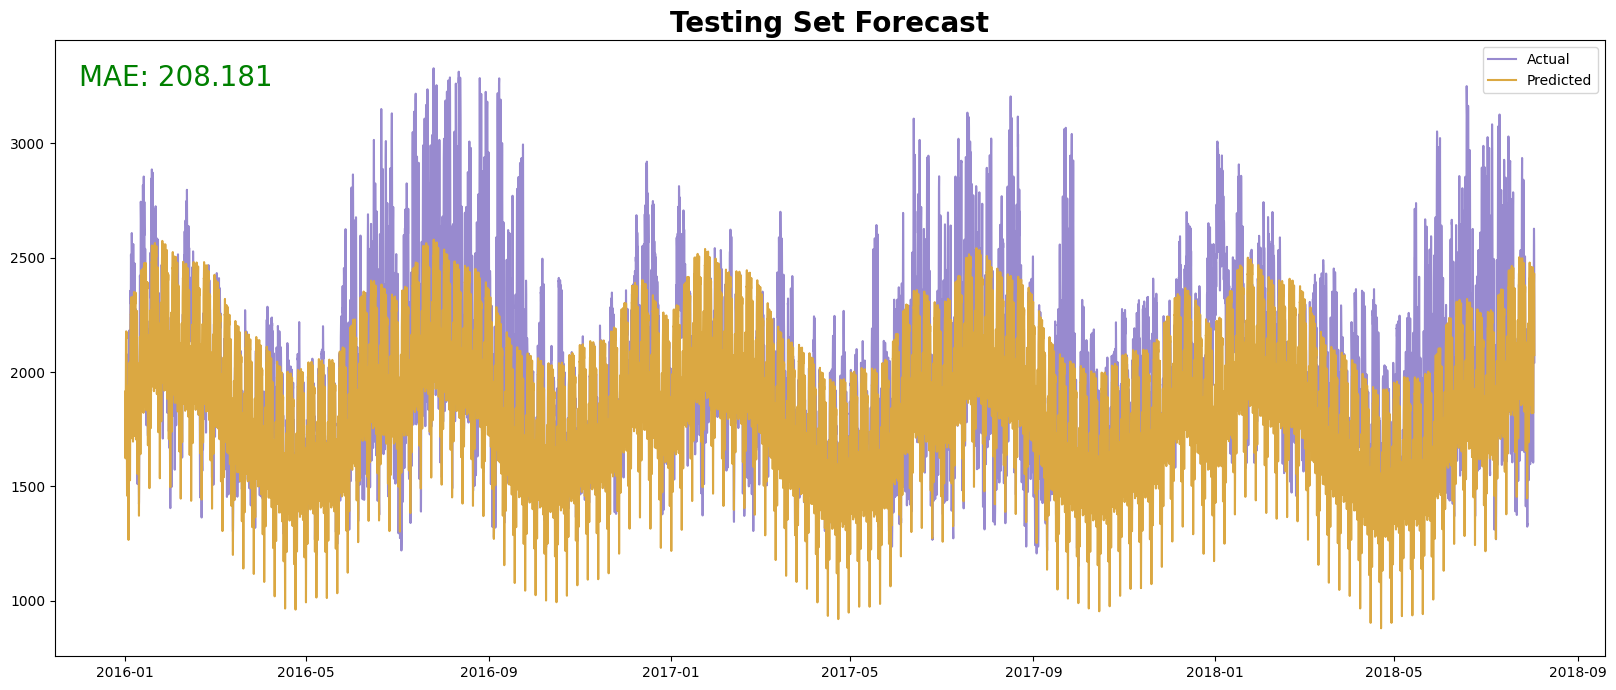

In [56]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='green')
plt.title('Testing Set Forecast', weight='bold', fontsize=20)
plt.legend()

<h2>Next 7 days prediction</h2>

In [57]:
new_df = index_to_column(df)

In [58]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)

# 7 days (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg1uqoar/zr88z022.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg1uqoar/g922aw3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45146', 'data', 'file=/tmp/tmpwg1uqoar/zr88z022.json', 'init=/tmp/tmpwg1uqoar/g922aw3o.json', 'output', 'file=/tmp/tmpwg1uqoar/prophet_modelvpp8hvgq/prophet_model-20240531191651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1500x500 with 0 Axes>

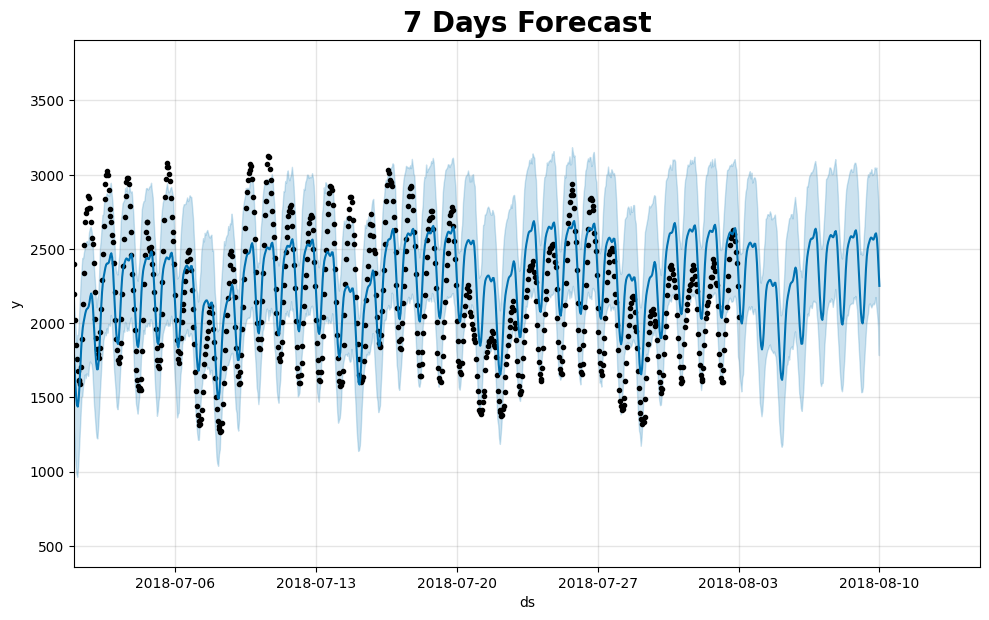

In [59]:
plt.figure(figsize=(15,5))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-15']))
plt.title('7 Days Forecast', weight='bold', fontsize=20)
plt.show()

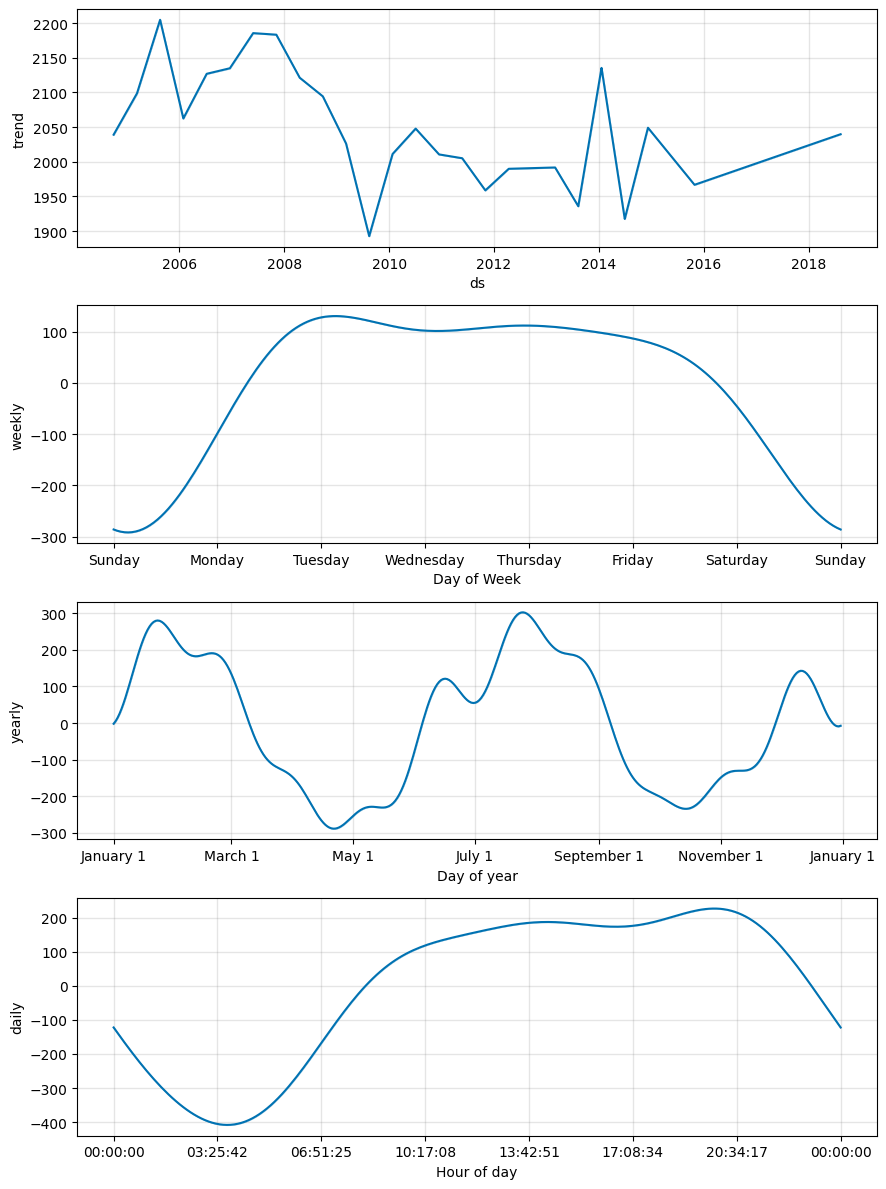

In [60]:
prophet_model.plot_components(prophet_pred2)
plt.show()

<Figure size 1500x500 with 0 Axes>

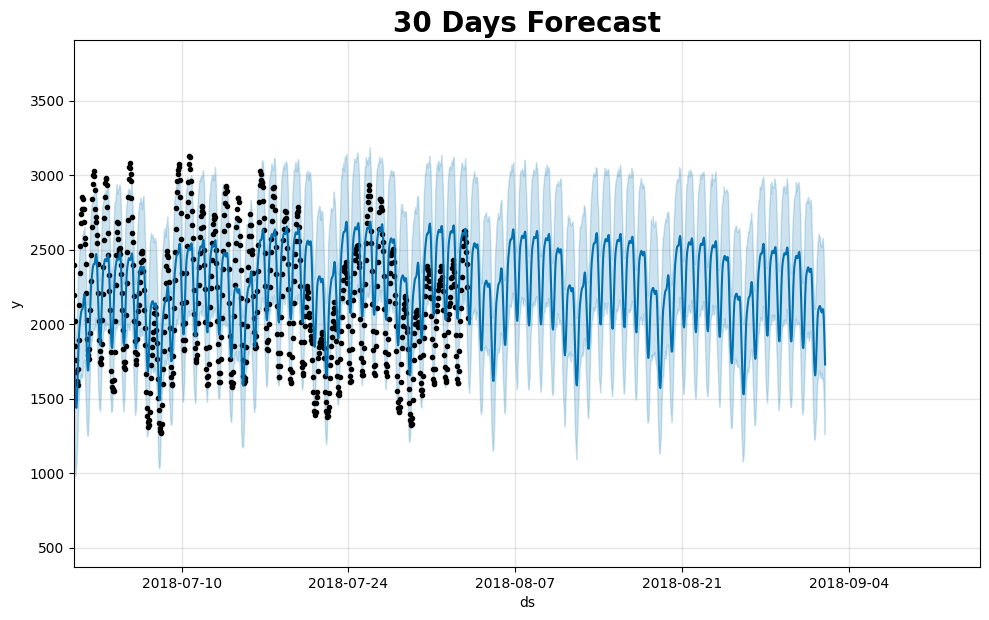

In [61]:
future_dates2 = prophet_model2.make_future_dataframe(periods=720, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)

plt.figure(figsize=(15,5))

fig = prophet_model2.plot(prophet_pred3, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-09-15']))
plt.title('30 Days Forecast', weight='bold', fontsize=20)
plt.show()

<h1><b>2. XGBoost</b></h1>

In [62]:
def date_transform(data):
    df = data.copy()

    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year

    X = df.drop('DAYTON_MW', axis=1)
    y = df['DAYTON_MW']

    return X, y

In [63]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

In [64]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-mae:302.82931	validation_1-mae:294.81783
[1]	validation_0-mae:292.60854	validation_1-mae:286.04103
[2]	validation_0-mae:283.08605	validation_1-mae:277.94648
[3]	validation_0-mae:274.32602	validation_1-mae:270.00067
[4]	validation_0-mae:266.09491	validation_1-mae:262.96200
[5]	validation_0-mae:258.49556	validation_1-mae:256.44171
[6]	validation_0-mae:251.34316	validation_1-mae:250.46317
[7]	validation_0-mae:244.65072	validation_1-mae:245.26214


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:238.35928	validation_1-mae:240.27141
[9]	validation_0-mae:232.54750	validation_1-mae:235.51407
[10]	validation_0-mae:227.06567	validation_1-mae:231.42270
[11]	validation_0-mae:222.17772	validation_1-mae:227.47613
[12]	validation_0-mae:217.48421	validation_1-mae:224.07702
[13]	validation_0-mae:213.24314	validation_1-mae:220.87648
[14]	validation_0-mae:209.29329	validation_1-mae:218.40160
[15]	validation_0-mae:205.41584	validation_1-mae:215.25050
[16]	validation_0-mae:201.72161	validation_1-mae:212.47264
[17]	validation_0-mae:198.22345	validation_1-mae:209.54239
[18]	validation_0-mae:195.28948	validation_1-mae:207.40498
[19]	validation_0-mae:192.10141	validation_1-mae:204.93002
[20]	validation_0-mae:189.25294	validation_1-mae:202.69755
[21]	validation_0-mae:186.62031	validation_1-mae:200.74895
[22]	validation_0-mae:184.28026	validation_1-mae:199.00984
[23]	validation_0-mae:182.01199	validation_1-mae:197.42155
[24]	validation_0-mae:179.85218	validation_1-mae:195.92214

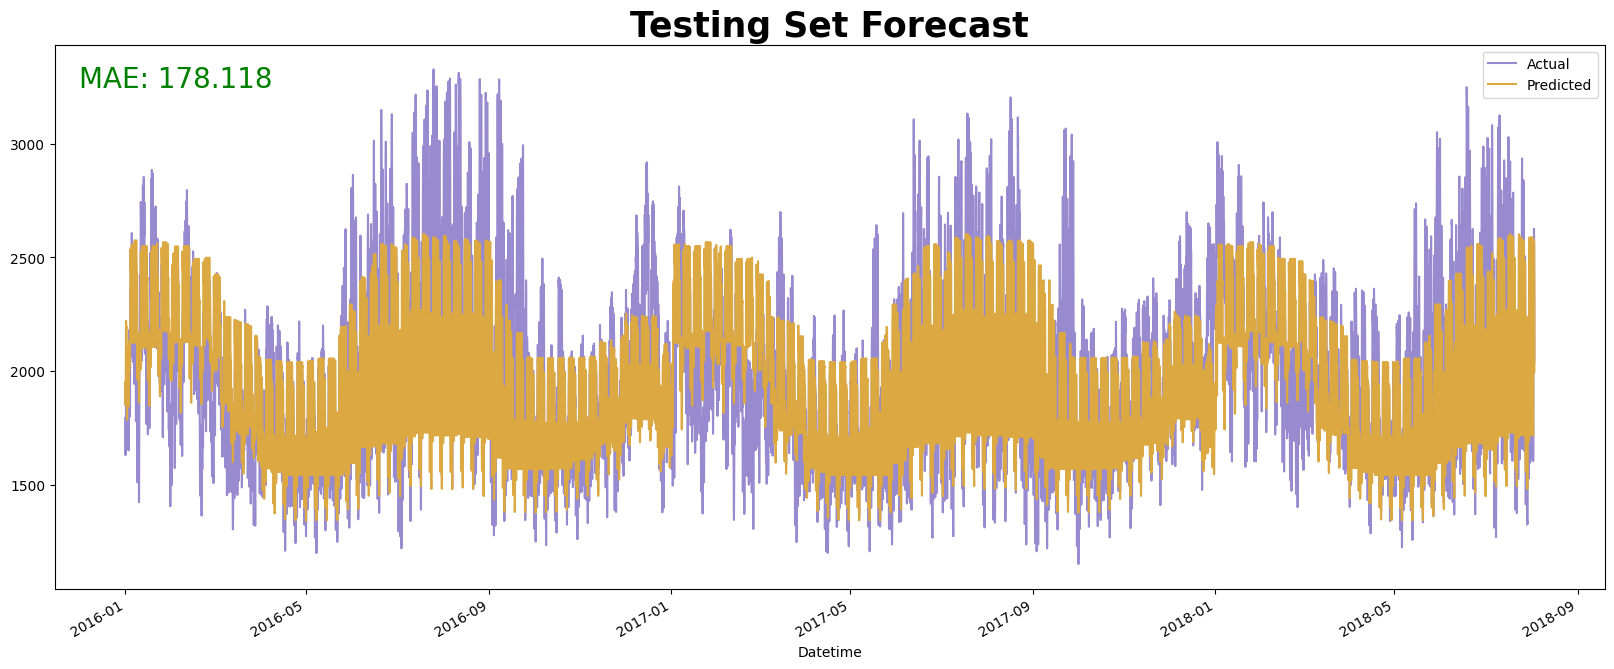

In [65]:
mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='green')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

<h2>Next 7 days prediction</h2>

In [66]:
future_dates2 = future_dates.iloc[-168:, :].copy()

future_dates2['ds'] = pd.to_datetime(future_dates2['ds'])
future_dates2 = future_dates2.set_index('ds')

future_dates2['Hour'] = future_dates2.index.hour
future_dates2['Dayofweek'] = future_dates2.index.dayofweek
future_dates2['Dayofmonth'] = future_dates2.index.day
future_dates2['Dayofyear'] = future_dates2.index.dayofyear
future_dates2['weekofyear'] = future_dates2.index.isocalendar().week
future_dates2['Month'] = future_dates2.index.month
future_dates2['Quarter'] = future_dates2.index.quarter
future_dates2['Year'] = future_dates2.index.year

In [67]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [68]:
xgb_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model2.fit(X, y, eval_metric='mae')
xgb_pred2 = xgb_model2.predict(future_dates2)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


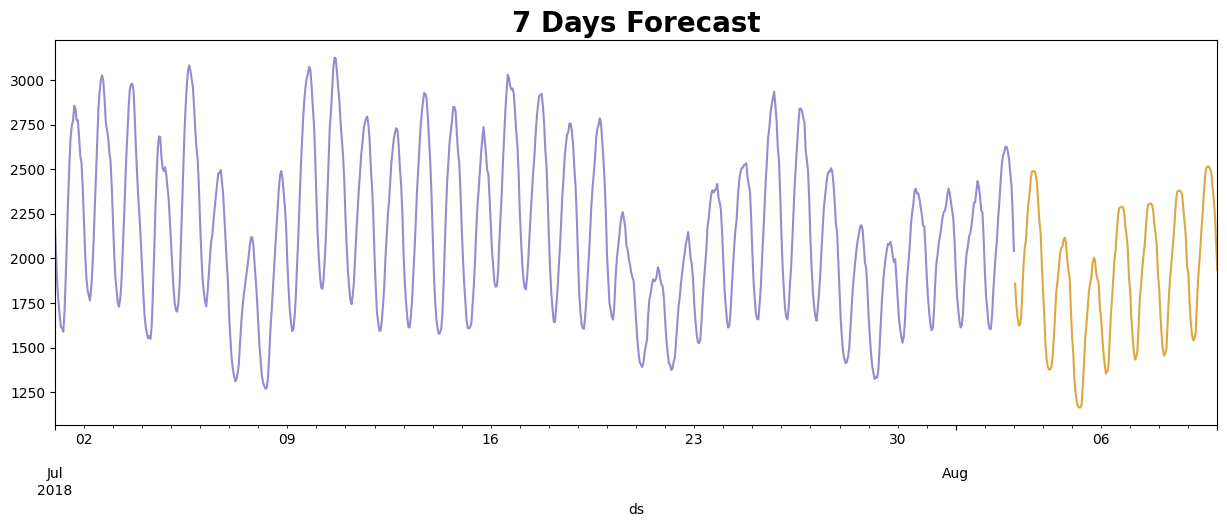

In [70]:
df_plot2 = pd.DataFrame({'Hour':future_dates2['Hour'], 'xgb_pred2':xgb_pred2})

last_week = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(15,5))

last_week['DAYTON_MW'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=20)
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


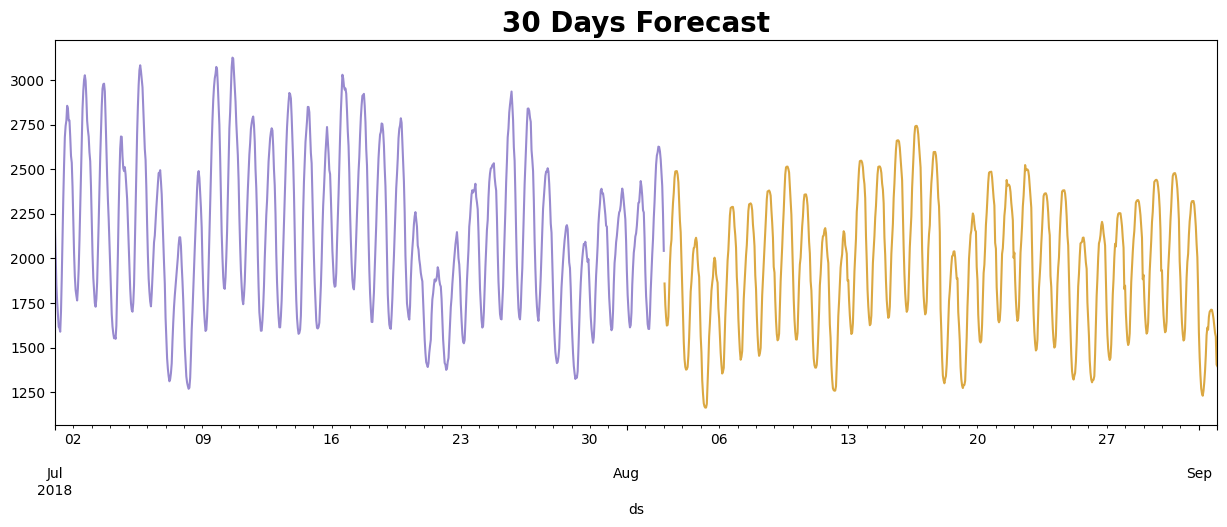

In [71]:
a = prophet_model2.make_future_dataframe(periods=720, freq='H')
future_dates3 = a.iloc[-720:, :].copy()

future_dates3['ds'] = pd.to_datetime(future_dates3['ds'])
future_dates3 = future_dates3.set_index('ds')

future_dates3['Hour'] = future_dates3.index.hour
future_dates3['Dayofweek'] = future_dates3.index.dayofweek
future_dates3['Dayofmonth'] = future_dates3.index.day
future_dates3['Dayofyear'] = future_dates3.index.dayofyear
future_dates3['weekofyear'] = future_dates3.index.isocalendar().week
future_dates3['Month'] = future_dates3.index.month
future_dates3['Quarter'] = future_dates3.index.quarter
future_dates3['Year'] = future_dates3.index.year

Xx = pd.concat([X_train, X_test], ignore_index=True)
yy = pd.concat([y_train, y_test], ignore_index=True)

xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(Xx, yy, eval_metric='mae')
xgb_pred3 = xgb_model3.predict(future_dates3)

df_plot3 = pd.DataFrame({'Hour':future_dates3['Hour'], 'xgb_pred2':xgb_pred3})

last_week3 = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(15,5))

last_week3['DAYTON_MW'].plot()
df_plot3['xgb_pred2'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=20)
plt.show()

<h1><b>3. Deep Neural Network<b></h1>

In [72]:
dataset = tf.expand_dims(df_train['DAYTON_MW'].head(10), axis=-1)

dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

dataset = dataset.map(lambda window: (window[:-1], window[-1]))

for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[1621.]
 [1536.]
 [1500.]
 [1434.]]
y =  [1489.]

x =  [[1536.]
 [1500.]
 [1434.]
 [1489.]]
y =  [1620.]

x =  [[1500.]
 [1434.]
 [1489.]
 [1620.]]
y =  [1859.]

x =  [[1434.]
 [1489.]
 [1620.]
 [1859.]]
y =  [2007.]

x =  [[1489.]
 [1620.]
 [1859.]
 [2007.]]
y =  [2025.]

x =  [[1620.]
 [1859.]
 [2007.]
 [2025.]]
y =  [2067.]



In [73]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [74]:
train = windowing(df_train['DAYTON_MW'], 24, 72, 32)
test = windowing(df_test['DAYTON_MW'], 24, 72, 32)

In [75]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4833 (18.88 KB)
Trainable params: 4833 (18.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
3081/3081 [==============================] - 127s 40ms/step - loss: 178.4184 - val_loss: 136.7422
Epoch 2/20
3081/3081 [==============================] - 102s 33ms/step - loss: 125.8694 - val_loss: 129.4224
Epoch 3/20
3081/3081 [==============================] - 91s 29ms/step - loss: 104.8883 - val_loss: 96.9303
Epoch 4/20
3081/3081 [==============================] - 89s 29ms/step - loss: 96.4547 - val_loss: 89.0142
Epoch 5/20
3081/3081 [==============================] - 89s 29ms/step - loss: 87.5304 - val_loss: 73.3856
Epoch 6/20
3081/3081 [==============================] - 89s 29ms/step - loss: 72.5866 - val_loss: 53.4502
Epoch 7/20
3081/3081 [==============================] - 87s 28ms/step - loss: 38.6457 - val_loss: 31.6854
Epoch 8/20
3081/3081 [==============================] - 88s 29ms/step - loss: 32.1780 - val_loss: 28.9645
Epoch 9/20
3081/3081 [==============================] - 87s 28ms/step - loss: 30.4350 - val_loss: 25.2342
Epoch 10/20
3081/3081 [================

<Axes: >

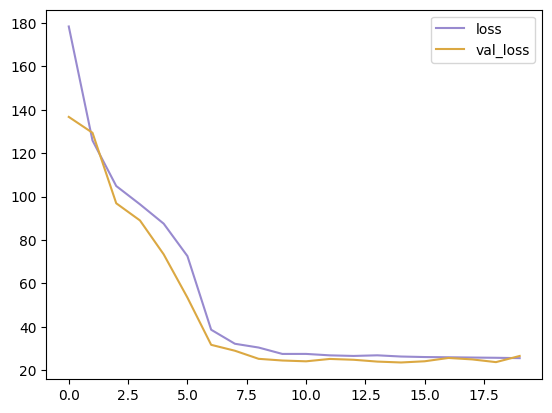

In [78]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [79]:
window_size = 24
forecast = []

train_length = len(df_train)
forecast_series = df[train_length - window_size:]

# Predicting data points per window size using the model
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Dropping single dimensional axes and converting to a numpy array
results = np.array(forecast).squeeze()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


<ipython-input-80-9588ef13e38f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred'] = results


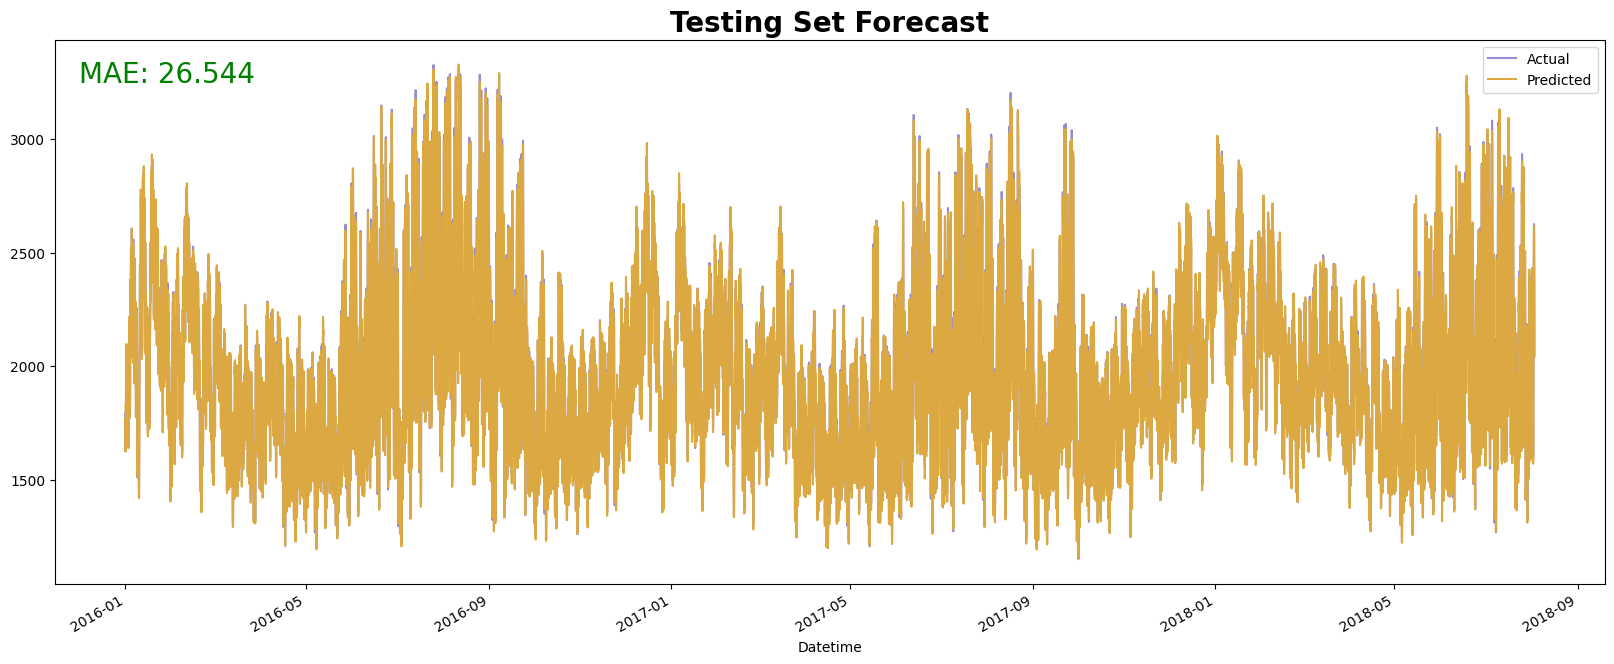

In [80]:
df_test['Pred'] = results

mae = round(mean_absolute_error(df_test['DAYTON_MW'], df_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'].plot(label='Actual')
df_test['Pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='green')
plt.title('Testing Set Forecast', weight='bold', fontsize=20)
plt.legend()
plt.show()

In [82]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(168): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    # Use .concat() instead of .append()
    df_forecast = pd.concat([df_forecast, pd.DataFrame({'Pred': [pred]})], ignore_index=True)

date_index = pd.date_range('2018-08-02 01:00:00', periods=192, freq='H') # 24+168
df_forecast.set_index(date_index, inplace=True)

1/1 [==============================] - 0s 43ms/step


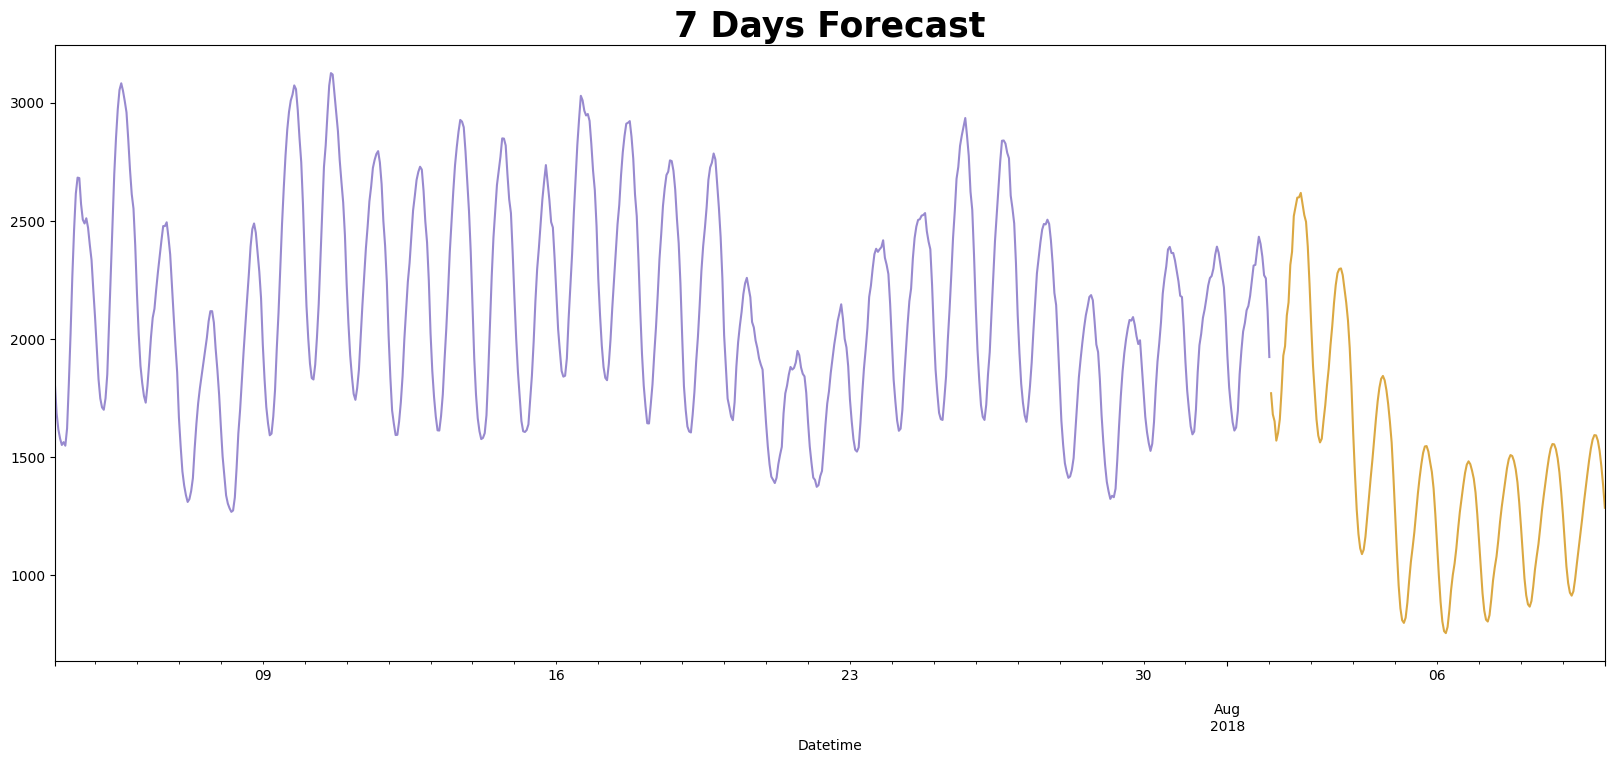

In [83]:
plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

1/1 [==============================] - 0s 27ms/step


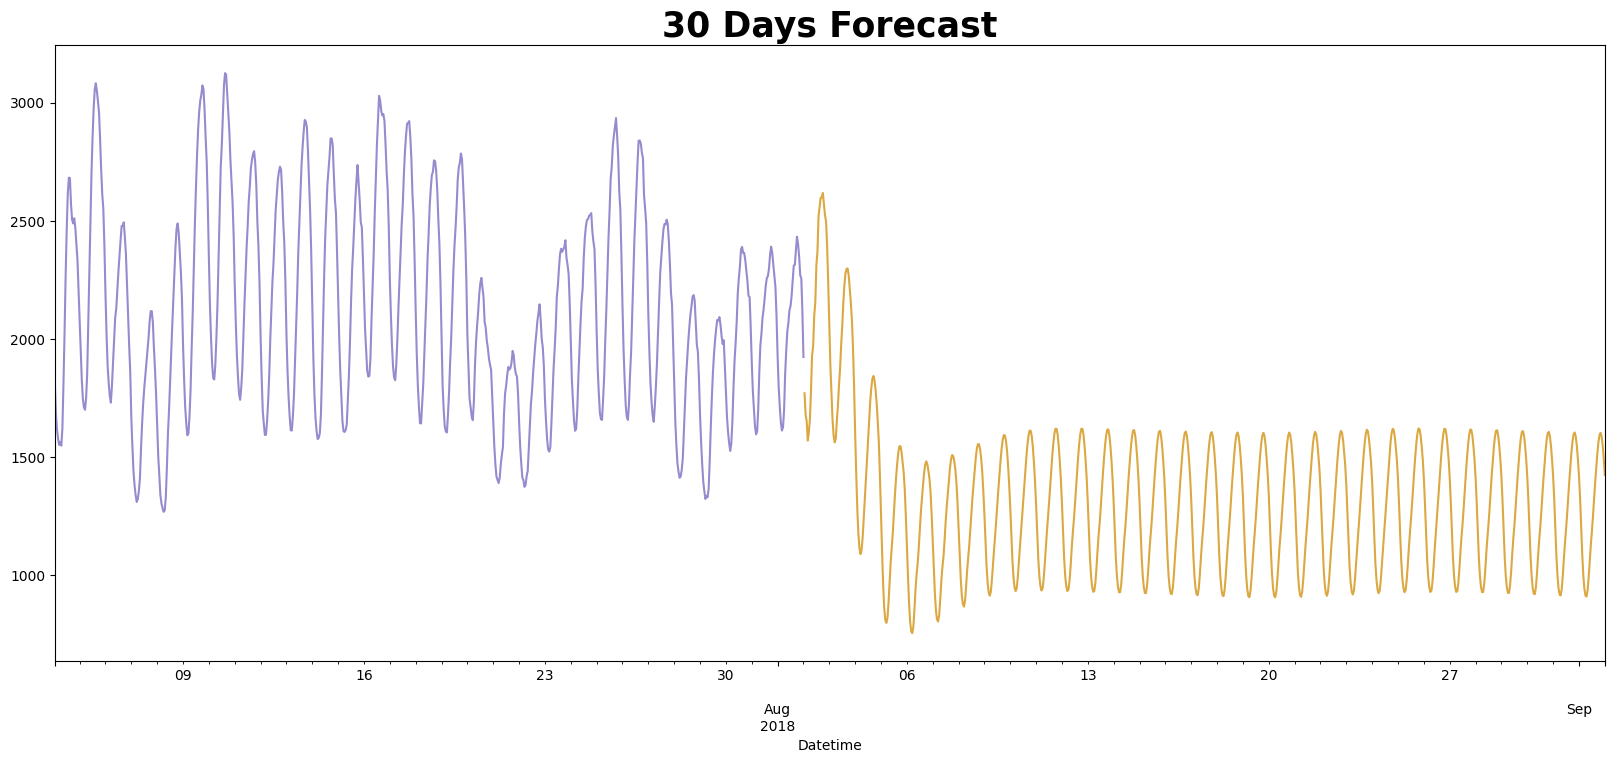

In [87]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(720): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    # Use .concat() instead of .append()
    df_forecast = pd.concat([df_forecast, pd.DataFrame({'Pred': [pred]})], ignore_index=True)

date_index = pd.date_range('2018-08-02 01:00:00', periods=744, freq='H') # 24+720
df_forecast.set_index(date_index, inplace=True)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

Based on above Time series of forecasts using three methods, we can conclude that the **DNN** performs better on our testing set. However, unlike **Prophet** and **XGBoost**, it struggles to forecast far into the future, as the predicted values tend to converge.